
[Evaluation - win5_vanc]
Accuracy : 0.3719
F1 Score : 0.2560
Recall   : 0.3719
Precision: 0.3536


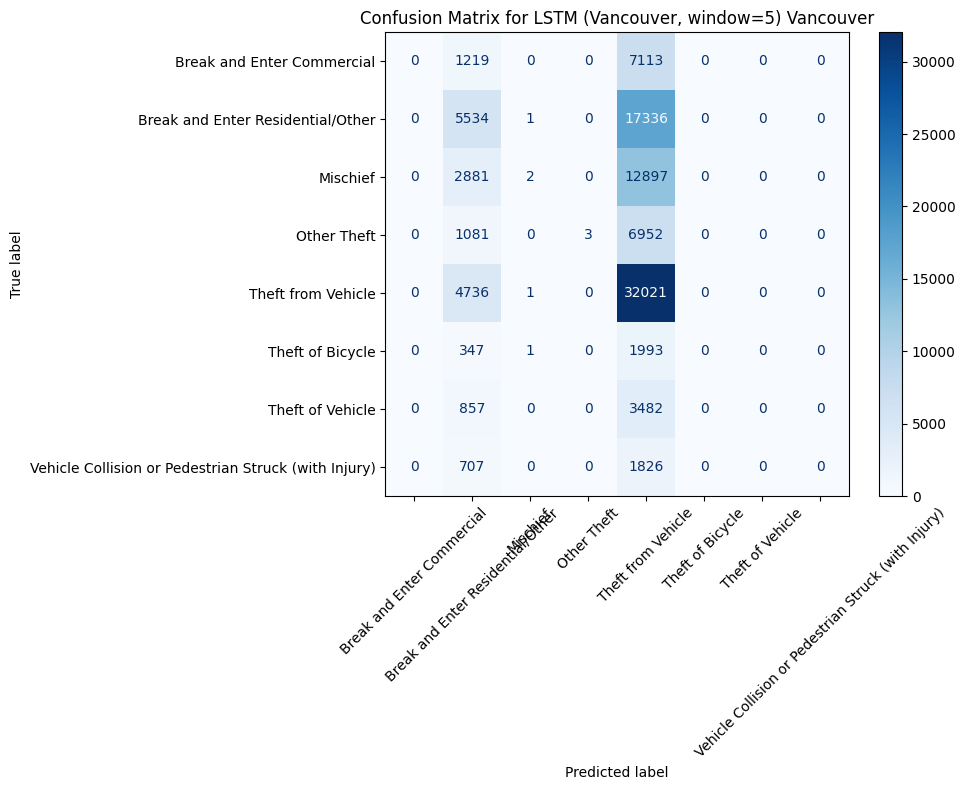

In [4]:
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# === Dataset ===
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# === Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# === Pencere Ayarı ve Dosya Etiketleri ===
window_size = 5 # It can be changable
tag = f"win{window_size}_vanc"
model_path = f"model_{tag}.pt"
scaler_path = f"scaler_{tag}.pkl"
encoder_path = f"label_encoder_{tag}.pkl"

# === Veriyi Yükle ve Özetle ===
vanc_df = pd.read_csv("crime.csv")

def build_daily_summary_vancouver(df):
    # Yeni DATE sütunu oluştur (datetime biçiminde)
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    df['DAY'] = df['DATE'].dt.date  # Sadece gün olarak tut

    grouped = df.groupby(['NEIGHBOURHOOD', 'DAY'])

    daily_features = []

    for (area, day), group in grouped:
        summary = {
            'NEIGHBOURHOOD': area,
            'DAY': day,
            'Crime_Count': len(group),
            'Crime_Mode': group['TYPE'].mode()[0] if not group['TYPE'].mode().empty else None
        }

        # Örnek histogram özellikleri (örnek kolonlara göre)
        for col in ['HOUR', 'MINUTE']:  
            summary[f"{col}_mean"] = group[col].mean()
            summary[f"{col}_max"] = group[col].max()

        daily_features.append(summary)

    return pd.DataFrame(daily_features)

daily_df = build_daily_summary_vancouver(vanc_df)

# Nadir sınıfları filtrele
value_counts = daily_df['Crime_Mode'].value_counts()
valid_classes = value_counts[value_counts >= 100].index
daily_df = daily_df[daily_df['Crime_Mode'].isin(valid_classes)].reset_index(drop=True)

# === Sequence oluştur ===
def create_sequences_rnn(daily_df, window_size=5, feature_cols=None):
    data = []
    labels = []

    if feature_cols is None:
        exclude = ['NEIGHBOURHOOD', 'DAY', 'Crime_Mode']
        feature_cols = [col for col in daily_df.columns if col not in exclude]

    grouped = daily_df.groupby('NEIGHBOURHOOD')

    for neigh, group in grouped:
        group = group.sort_values(by='DAY').reset_index(drop=True)
        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            target_day = group.iloc[i+window_size]

            if pd.isnull(target_day['Crime_Mode']):
                continue

            x_seq = window[feature_cols].values.astype(np.float32)
            y_label = target_day['Crime_Mode']
            data.append(x_seq)
            labels.append(y_label)

    return np.array(data), np.array(labels), feature_cols

X, y, feature_cols = create_sequences_rnn(daily_df, window_size=window_size)

# === Artifacts yükle ===
scaler = joblib.load(scaler_path)
le = joblib.load(encoder_path)

n, t, f = X.shape
X_scaled = scaler.transform(X.reshape(-1, f)).reshape(n, t, f)
y_encoded = le.transform(y)

# === Dataloader ===
test_dataset = CrimeDataset(X_scaled, y_encoded)
test_loader = DataLoader(test_dataset, batch_size=32)

# === Model yükle ===
input_dim = X.shape[2]
output_dim = len(le.classes_)
model = LSTMClassifier(input_dim=input_dim, hidden_dim=128, output_dim=output_dim)
model.load_state_dict(torch.load(model_path))
model.eval()

# === Tahmin ve Değerlendirme ===
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')

print(f"\n[Evaluation - {tag}]")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"Precision: {prec:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=plt.gca(), xticks_rotation=45)
plt.title(f"Confusion Matrix for LSTM (Vancouver, window={window_size}) Vancouver")
plt.tight_layout()
plt.show()